In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import preprocess_dataset as ut
from scipy.interpolate import BSpline
from tfkan import DenseKAN
from tensorflow import keras
from keras_tuner import HyperModel, GridSearch, RandomSearch

In [2]:
x_train = pd.read_csv("datasets/x_train.csv").to_numpy()[:, 1:]
y_train = pd.read_csv("datasets/y_train.csv").to_numpy()[:, 1:]

ut.standardize(x_train)

x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)

my_record = x_train[0]

In [41]:
n = 8
k = 3
dim_in_1 = 25
dim_out_1 = 4
dim_out_2 = 1

scale_factor_1 = np.random.normal(size=(dim_in_1, dim_out_1))
scale_factor_2 = np.random.normal(size=(dim_out_1, dim_out_2))

n_splines = dim_in_1 * dim_out_1
kernel = np.random.normal(size=(n, dim_in_1 * dim_out_1))
t = np.linspace(0, 1, n+k+1)
splines = [BSpline(t, kernel[:,i], k) for i in range(n_splines)]
splines = np.reshape(splines, (dim_in_1, dim_out_1))
layer2 = np.zeros(dim_out_1)
for i in range(splines.shape[1]):
    for j in range(splines.shape[0]):
        layer2[i] += scale_factor_1[j,i] * splines[j,i](my_record[i])

n_splines_2 = dim_out_1 * dim_out_2
kernel = np.random.normal(size=(n, dim_out_1 * dim_out_2))
t = np.linspace(0, 1, n+k+1)
splines_2 = [BSpline(t, kernel[:,i], k) for i in range(n_splines_2)]
splines_2 = np.reshape(splines_2, (dim_out_1, dim_out_2))
layer3 = np.zeros(dim_out_2)
for i in range(splines_2.shape[1]):
    for j in range(splines_2.shape[0]):
        layer3[i] += scale_factor_2[j,i] * splines_2[j,i](layer2[i])

print(layer2)
print(layer3)


[  -3.34090983  -37.18824759   -9.41150155 -159.04537353]
[127572.91629403]
(25, 4)


$$
\Phi_{l} = 
\begin{bmatrix}
\phi_{11} & \phi_{12} & \cdots & \phi_{1n} \\
\phi_{21} & \phi_{22} & \cdots & \phi_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{m1} & \phi_{m2} & \cdots & \phi_{mn}
\end{bmatrix}
$$
Dove 
$$
\phi(x) = w_bb(x) + w_s\sum_i{c_iB_i(x)}
$$

(4,) (25,) (25, 4)
bias: [4]
basis_act: [25]
kernel: [25  8  4]
scale_factor: [25  4]
Matrix: (4, 25)


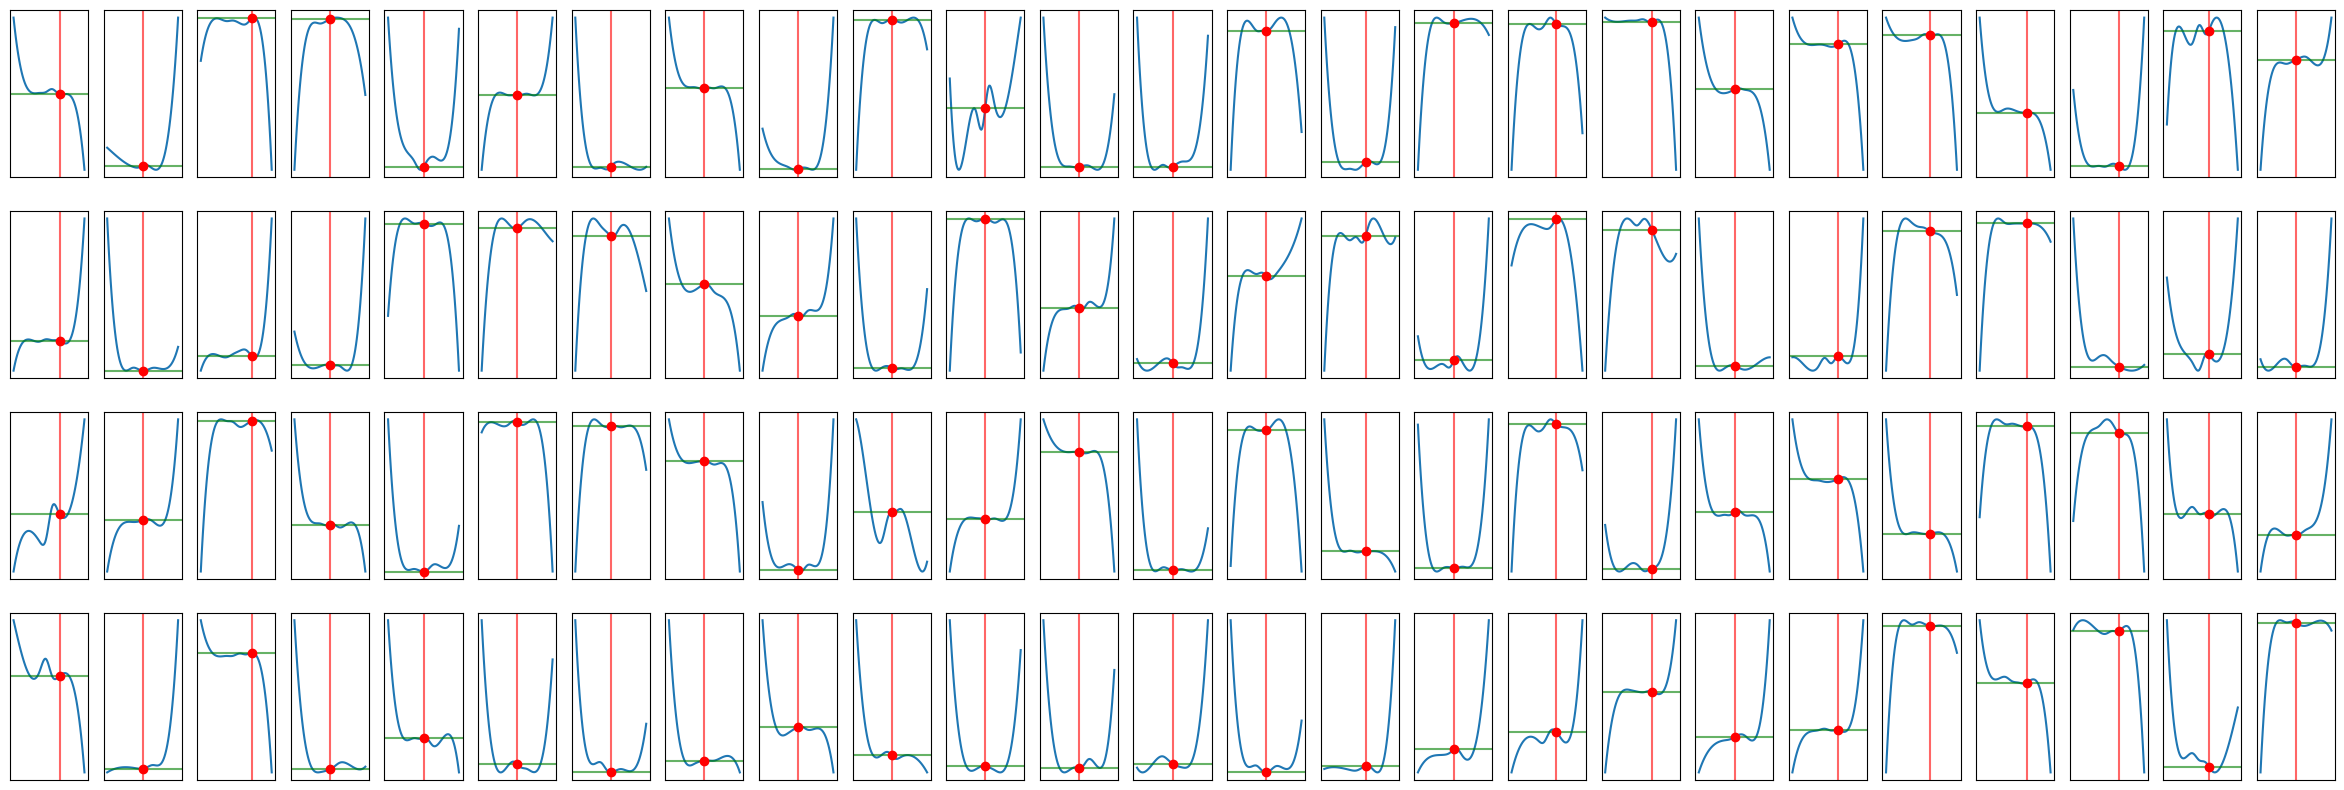

In [10]:
input_dim = x_train.shape[1]
layer1_dim = 4

# Architettura del modello
model = tf.keras.models.Sequential([
    DenseKAN(layer1_dim),
    # DenseKAN(1)
])

# Compilazione del modello
model.build(input_shape=(None, input_dim))
# model.compile(loss='mse', optimizer='adam', metrics=['mse'])
# model.fit(x_train, y_train, epochs=10, batch_size=128)

# predizione = model.predict(tf.reshape(my_record, (1, input_dim)))
# print(predizione)

# Configurazione dell'area grafica
nrows = int(model.layers[0].units)
ncols = int(model.layers[0].input_dim)

fig, axes = plt.subplots(nrows, ncols, figsize=(30, 10))
axes = axes.flatten()

# Spline e parametri
spline_list = model.layers[0].spline_list
num_splines = len(spline_list)

w_s = np.array(model.layers[0].scale_factor)
b_act = np.array(model.layers[0].basis_activation(my_record))
# b_act = np.array([b_act] * nrows)
biases = np.array(model.layers[0].bias)
# biases = np.array([biases] * ncols)
print(biases.shape, b_act.shape, w_s.shape)
# print(num_splines)

# print(f"spline_out: {tf.shape(spline_out)}")
print(f"bias: {tf.shape(model.layers[0].bias)}")
print(f"basis_act: {tf.shape(model.layers[0].basis_activation(my_record))}")
print(f"kernel: {tf.shape(model.layers[0].spline_kernel)}")
print(f"scale_factor: {tf.shape(model.layers[0].scale_factor)}")

layer1_matrix = np.zeros(nrows * ncols)

for i, spline in enumerate(spline_list):
    xx = np.linspace(spline.t[0], spline.t[-1], 100)
    yy = spline(xx)
    axes[i].plot(xx, yy)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].axvline(x=my_record[i%input_dim], color='red', alpha=0.6)
    axes[i].axhline(y=spline(my_record[i%input_dim]), color='green', alpha=0.6)
    axes[i].plot(my_record[i%input_dim], spline(my_record[i%input_dim]), 'ro')
    layer1_matrix[i] = spline(my_record[i%input_dim])


layer1_matrix = np.reshape(layer1_matrix, (nrows, ncols))
print(f"Matrix: {layer1_matrix.shape}")
# print(biases.shape, b_act.shape, w_s.shape, layer1_matrix.shape)
# layer1_matrix = b_act @ biases + layer1_matrix @ w_s # Formula del paper (senza bias perché i coefficienti sono inizializzati a 0)
# print(layer1_matrix.shape)
plt.show()

$$
KAN(x) = \sum_{i_{1}=1}^{5}{\phi_{1}(\sum_{i_{0}=1}^{26}{\phi_{0}(x_{i_0})})}
$$

In [4]:
spline_list = model.layers[1].spline_list
num_splines = len(spline_list)

# Configurazione dell'area grafica
nrows = int(model.layers[1].units)
ncols = int(model.layers[1].input_dim)

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 5))
axes = axes.flatten()

w_s_2 = np.array(model.layers[1].scale_factor)
b_act_input = []

w_s_2 = np.array(model.layers[1].scale_factor)
b_act_2 = np.array(model.layers[1].basis_activation(my_record))
b_act_2 = np.array([b_act_2] * nrows)
biases_2 = np.array(model.layers[1].bias)
biases_2 = np.array([biases_2] * ncols)

layer2_matrix = np.zeros(layer1_dim)

for i, spline in enumerate(spline_list):
    xx = np.linspace(spline.t[0], spline.t[-1], 100)
    yy = spline(xx)
    axes[i].plot(xx, yy)
    axes[i].axvline(x=sum(layer1_matrix[i]), color='red', alpha=0.6)
    axes[i].axhline(y=spline(sum(layer1_matrix[i])), color='green', alpha=0.6)
    axes[i].plot(sum(layer1_matrix[i]), spline(sum(layer1_matrix[i])), 'ro')
    layer2_matrix[i] = spline(sum(layer1_matrix[i]))
    b_act_input.append(sum(layer1_matrix[i]))

b_act = np.array(model.layers[1].basis_activation(b_act_input))

print(biases_2.shape, b_act_2.shape, w_s_2.shape, layer2_matrix.shape)
layer2_matrix = b_act_2 @ biases_2 + layer2_matrix @ w_s_2
plt.show()

IndexError: list index out of range

In [ ]:
final_result = sum(layer2_matrix[0])
print(f"Output della rete: {final_result}")

Output della rete: 46.47953054316724
